# Property Price Prediction dengan XGBoost, Random Forest & CatBoost

Notebook ini akan membangun model machine learning untuk memprediksi harga properti di Surabaya menggunakan tiga algoritma utama:
- **Random Forest Regressor**
- **XGBoost Regressor** 
- **CatBoost Regressor**

Dataset yang digunakan:
- `/data/raw/Dataset_Bangunan_Surabaya_Final_Revisi_.csv` - Data properti bangunan
- `/data/raw/dataset_tanah_njop_surabaya_sertifikat.csv` - Data tanah dan NJOP

**Target**: Memprediksi harga properti berdasarkan fitur-fitur seperti lokasi, luas tanah, luas bangunan, dan fasilitas.

## 1. Import Library yang Dibutuhkan

In [1]:
# Data manipulation dan analisis
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')

# Machine Learning - preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Machine Learning - models
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from catboost import CatBoostRegressor

# Utilitas
import joblib
import os
from datetime import datetime

print("✅ Semua library berhasil diimport!")
print(f"📊 Pandas version: {pd.__version__}")
print(f"🔥 XGBoost version: {xgb.__version__}")
print(f"🐱 CatBoost version: {catboost.__version__}" if 'catboost' in globals() else "🐱 CatBoost ready!")

✅ Semua library berhasil diimport!
📊 Pandas version: 2.3.0
🔥 XGBoost version: 3.0.2
🐱 CatBoost ready!


## 2. Load dan Eksplorasi Data Properti

In [2]:
# Load dataset
print("📁 Loading datasets...")

# Path ke data
data_dir = "../data/raw/"
building_file = "Dataset_Bangunan_Surabaya_Final_Revisi_.csv"
land_file = "dataset_tanah_njop_surabaya_sertifikat.csv"

try:
    # Load data bangunan
    df_building = pd.read_csv(os.path.join(data_dir, building_file))
    print(f"✅ Data bangunan berhasil dimuat: {df_building.shape}")
    
    # Load data tanah NJOP
    df_land = pd.read_csv(os.path.join(data_dir, land_file))
    print(f"✅ Data tanah berhasil dimuat: {df_land.shape}")
    
except FileNotFoundError as e:
    print(f"❌ Error: {e}")
    print("🔍 Cek path dan nama file dataset!")

📁 Loading datasets...
✅ Data bangunan berhasil dimuat: (8980, 22)
✅ Data tanah berhasil dimuat: (1000, 10)


In [3]:
# Eksplorasi data bangunan
print("🏢 EKSPLORASI DATA BANGUNAN")
print("=" * 50)
print(f"Shape: {df_building.shape}")
print(f"Columns: {list(df_building.columns)}")
print("\n📋 Info Dataset:")
df_building.info()

print("\n📊 Sample data:")
df_building.head()

🏢 EKSPLORASI DATA BANGUNAN
Shape: (8980, 22)
Columns: ['Kecamatan', 'Kamar Tidur', 'Kamar Mandi', 'Luas Tanah', 'Luas Bangunan', 'Sertifikat', 'Daya Listrik', 'Ruang Makan', 'Ruang Tamu', 'Kondisi Perabotan', 'Jumlah Lantai', 'Hadap', 'Terjangkau Internet', 'Lebar Jalan', 'Sumber Air', 'Hook', 'Kondisi Properti', 'Alamat', 'Tipe Iklan', 'Aksesibilitas', 'NJOP_Rp_per_m2', 'Tingkat_Keamanan']

📋 Info Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8980 entries, 0 to 8979
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Kecamatan            8980 non-null   object 
 1   Kamar Tidur          8980 non-null   int64  
 2   Kamar Mandi          8980 non-null   int64  
 3   Luas Tanah           8980 non-null   int64  
 4   Luas Bangunan        8980 non-null   int64  
 5   Sertifikat           8980 non-null   object 
 6   Daya Listrik         6815 non-null   float64
 7   Ruang Makan          6618 n

,Kecamatan,Kamar Tidur,Kamar Mandi,Luas Tanah,Luas Bangunan,Sertifikat,Daya Listrik,Ruang Makan,Ruang Tamu,Kondisi Perabotan,...,Terjangkau Internet,Lebar Jalan,Sumber Air,Hook,Kondisi Properti,Alamat,Tipe Iklan,Aksesibilitas,NJOP_Rp_per_m2,Tingkat_Keamanan
0,Wonokromo,3,2,45,70,SHM - Sertifikat Hak Milik,1300.0,Tidak,Tidak,Unfurnished,...,Tidak,NaN,NaN,Tidak,Baru,"Jl. Wonokromo Raya No.103, Surabaya (-7.356339...",Keduanya,Baik,1032000.0,Tinggi
1,Rungkut,3,2,48,2023,SHM - Sertifikat Hak Milik,1300.0,Ya,Ya,Unfurnished,...,Ya,2 Mobil,PAM atau PDAM,Tidak,Baru,"Jl. Rungkut Raya No.180, Surabaya (-7.389061, ...",Keduanya,Baik,1032000.0,Tinggi
2,Semampir,3,3,48,85,SHM - Sertifikat Hak Milik,1300.0,Ya,Ya,Unfurnished,...,Ya,2 Mobil,PAM atau PDAM,Tidak,Bagus,"Jl. Semampir Raya No.93, Surabaya (-7.396466, ...",Keduanya,Baik,1274000.0,Rendah
3,Pakal,2,1,50,91,HGB - Hak Guna Bangunan,1300.0,Ya,Ya,Unfurnished,...,Ya,2 Mobil,Sumur Pompa,Ya,Baru,"Jl. Pakal Raya No.15, Surabaya (-7.379446, 112...",Disewa,Buruk,1032000.0,Rendah
4,Gayungan,2,2,51,50,SHM - Sertifikat Hak Milik,2200.0,Tidak,Tidak,Unfurnished,...,Tidak,NaN,PAM atau PDAM,Tidak,Baru,"Jl. Gayungan Raya No.107, Surabaya (-7.365561,...",Disewa,Baik,1032000.0,Tinggi


In [7]:
# Eksplorasi data tanah NJOP
print("🌍 EKSPLORASI DATA TANAH & NJOP")
print("=" * 50)
print(f"Shape: {df_land.shape}")
print(f"Columns: {list(df_land.columns)}")
print("\n📋 Info Dataset:")
df_land.info()

print("\n📊 Sample data:")
df_land.head()

# Standardisasi nama kolom  
print("=== STANDARDISASI NAMA KOLOM ===")
df_building.columns = df_building.columns.str.lower().str.replace(' ', '_')
df_land.columns = df_land.columns.str.lower().str.replace(' ', '_')

# Rename untuk konsistensi dengan nama yang sudah digunakan
df_bangunan = df_building.copy()
df_tanah = df_land.copy()

# Membuat kolom target 'harga_properti' berdasarkan estimasi NJOP
# Karena tidak ada kolom harga langsung, kita estimasi dari NJOP dan luas bangunan
print("Membuat kolom target harga_properti...")
df_bangunan['harga_properti'] = df_bangunan['njop_rp_per_m2'] * df_bangunan['luas_bangunan'] * 1.2  # faktor markup

# Standardisasi nama kolom untuk konsistensi
df_bangunan['luas_bangunan_m2'] = df_bangunan['luas_bangunan']
df_bangunan['luas_tanah_m2'] = df_bangunan['luas_tanah'] 
df_bangunan['jumlah_kamar_tidur'] = df_bangunan['kamar_tidur']
df_bangunan['jumlah_kamar_mandi'] = df_bangunan['kamar_mandi']
df_bangunan['jumlah_garasi'] = 1  # default 1 garasi
df_bangunan['tahun_dibangun'] = 2020  # default tahun

print("Kolom data bangunan setelah standardisasi:")
print(df_bangunan.columns.tolist())

print(f"\nTarget variable (harga_properti) statistics:")
print(f"Min: Rp {df_bangunan['harga_properti'].min():,.0f}")
print(f"Max: Rp {df_bangunan['harga_properti'].max():,.0f}")
print(f"Mean: Rp {df_bangunan['harga_properti'].mean():,.0f}")
print(f"Median: Rp {df_bangunan['harga_properti'].median():,.0f}")

🌍 EKSPLORASI DATA TANAH & NJOP
Shape: (1000, 10)
Columns: ['kecamatan', 'kelurahan', 'luas_tanah_m2', 'njop_tanah_m2', 'njop_total', 'zona_nilai_tanah', 'kelas_tanah', 'tahun', 'jenis_sertifikat', 'no_sertifikat']

📋 Info Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   kecamatan         1000 non-null   object
 1   kelurahan         1000 non-null   object
 2   luas_tanah_m2     1000 non-null   int64 
 3   njop_tanah_m2     1000 non-null   int64 
 4   njop_total        1000 non-null   int64 
 5   zona_nilai_tanah  1000 non-null   int64 
 6   kelas_tanah       1000 non-null   object
 7   tahun             1000 non-null   int64 
 8   jenis_sertifikat  1000 non-null   object
 9   no_sertifikat     669 non-null    object
dtypes: int64(5), object(5)
memory usage: 78.3+ KB

📊 Sample data:
=== STANDARDISASI NAMA KOLOM ===
Membuat kol

In [5]:
# Cek missing values dan statistik deskriptif
print("🔍 ANALISIS MISSING VALUES")
print("=" * 50)

print("📊 Missing values - Data Bangunan:")
missing_building = df_building.isnull().sum()
print(missing_building[missing_building > 0])

print("\n📊 Missing values - Data Tanah:")
missing_land = df_land.isnull().sum() 
print(missing_land[missing_land > 0])

print("\n📈 STATISTIK DESKRIPTIF - Data Bangunan:")
df_building.describe()

🔍 ANALISIS MISSING VALUES
📊 Missing values - Data Bangunan:
Daya Listrik           2165
Ruang Makan            2362
Ruang Tamu              566
Jumlah Lantai            39
Hadap                  3129
Terjangkau Internet     564
Lebar Jalan            4387
Sumber Air             3019
Hook                    564
Kondisi Properti        380
dtype: int64

📊 Missing values - Data Tanah:
no_sertifikat    331
dtype: int64

📈 STATISTIK DESKRIPTIF - Data Bangunan:


,Kamar Tidur,Kamar Mandi,Luas Tanah,Luas Bangunan,Daya Listrik,Jumlah Lantai,NJOP_Rp_per_m2
count,8980.000000,8980.000000,8980.000000,8980.000000,6815.000000,8941.000000,8.980000e+03
mean,3.546214,2.674610,187.124165,205.688085,2981.276596,1.634716,1.017278e+06
std,1.075697,1.049781,140.574192,157.436695,1749.447936,0.540629,3.273322e+04
min,1.000000,1.000000,45.000000,50.000000,900.000000,1.000000,1.000000e+06
25%,3.000000,2.000000,97.000000,110.000000,2200.000000,1.000000,1.000000e+06
50%,3.000000,3.000000,135.000000,160.000000,2200.000000,2.000000,1.000000e+06
75%,4.000000,3.000000,230.000000,250.000000,3500.000000,2.000000,1.032000e+06
max,7.000000,8.000000,1000.000000,3300.000000,17600.000000,4.000000,1.274000e+06


## 3. Preprocessing Data

In [8]:
# Preprocessing data bangunan
print("🧹 PREPROCESSING DATA BANGUNAN")
print("=" * 50)

# Copy data untuk preprocessing
df_building_clean = df_building.copy()

# Handle missing values untuk kolom numerik
numeric_cols = ['Daya Listrik', 'Jumlah Lantai', 'Luas Tanah', 'Luas Bangunan', 'NJOP_Rp_per_m2']

for col in numeric_cols:
    if col in df_building_clean.columns:
        # Fill missing values dengan median
        median_val = df_building_clean[col].median()
        df_building_clean[col].fillna(median_val, inplace=True)
        print(f"✅ {col}: Missing values diisi dengan median ({median_val})")

# Handle missing values untuk kolom kategorikal
categorical_cols = ['Hadap', 'Lebar Jalan', 'Sumber Air', 'Kondisi Properti']

for col in categorical_cols:
    if col in df_building_clean.columns:
        # Fill missing values dengan mode (nilai paling sering)
        mode_val = df_building_clean[col].mode().iloc[0] if not df_building_clean[col].mode().empty else 'Unknown'
        df_building_clean[col].fillna(mode_val, inplace=True)
        print(f"✅ {col}: Missing values diisi dengan mode ({mode_val})")

print(f"\n📊 Shape setelah cleaning: {df_building_clean.shape}")
print(f"🔍 Missing values tersisa: {df_building_clean.isnull().sum().sum()}")

🧹 PREPROCESSING DATA BANGUNAN

📊 Shape setelah cleaning: (8980, 22)
🔍 Missing values tersisa: 17175


In [10]:
# Encoding Kolom Kategorikal
print("🔤 ENCODING KOLOM KATEGORIKAL")
print("=" * 50)

# Identify categorical columns
categorical_columns = df_bangunan.select_dtypes(include=['object']).columns.tolist()
print(f"Kolom kategorikal yang ditemukan: {categorical_columns}")

# Exclude non-predictive columns
exclude_columns = ['alamat', 'kecamatan']  # alamat terlalu spesifik, kecamatan bisa dipertahankan
categorical_for_encoding = [col for col in categorical_columns if col not in exclude_columns]

print(f"Kolom untuk encoding: {categorical_for_encoding}")

# One-hot encoding untuk kolom kategorikal
from sklearn.preprocessing import LabelEncoder

# Label encoding untuk kolom ordinal
ordinal_columns = ['kondisi_properti', 'tingkat_keamanan', 'aksesibilitas']
le_dict = {}

for col in ordinal_columns:
    if col in df_bangunan.columns:
        le = LabelEncoder()
        df_bangunan[col + '_encoded'] = le.fit_transform(df_bangunan[col].fillna('unknown'))
        le_dict[col] = le
        print(f"✅ Label encoded: {col}")

# One-hot encoding untuk kolom nominal
nominal_columns = [col for col in categorical_for_encoding if col not in ordinal_columns]
print(f"Kolom untuk One-hot encoding: {nominal_columns}")

# Lakukan one-hot encoding
df_encoded = pd.get_dummies(df_bangunan, columns=nominal_columns, prefix=nominal_columns, dummy_na=True)

# Update dataframe
df_bangunan = df_encoded

print(f"📊 Shape setelah encoding: {df_bangunan.shape}")
print(f"📝 Kolom baru: {df_bangunan.shape[1] - 22} kolom ditambahkan")

# Tampilkan beberapa kolom baru
new_columns = [col for col in df_bangunan.columns if any(prefix in col for prefix in nominal_columns)]
if new_columns:
    print(f"Contoh kolom baru: {new_columns[:5]}")
else:
    print("Tidak ada kolom baru yang dibuat")

🔤 ENCODING KOLOM KATEGORIKAL
Kolom kategorikal yang ditemukan: ['kecamatan', 'sertifikat', 'ruang_makan', 'ruang_tamu', 'kondisi_perabotan', 'hadap', 'terjangkau_internet', 'lebar_jalan', 'sumber_air', 'hook', 'kondisi_properti', 'alamat', 'tipe_iklan', 'aksesibilitas', 'tingkat_keamanan']
Kolom untuk encoding: ['sertifikat', 'ruang_makan', 'ruang_tamu', 'kondisi_perabotan', 'hadap', 'terjangkau_internet', 'lebar_jalan', 'sumber_air', 'hook', 'kondisi_properti', 'tipe_iklan', 'aksesibilitas', 'tingkat_keamanan']
✅ Label encoded: kondisi_properti
✅ Label encoded: tingkat_keamanan
✅ Label encoded: aksesibilitas
Kolom untuk One-hot encoding: ['sertifikat', 'ruang_makan', 'ruang_tamu', 'kondisi_perabotan', 'hadap', 'terjangkau_internet', 'lebar_jalan', 'sumber_air', 'hook', 'tipe_iklan']
📊 Shape setelah encoding: (8980, 66)
📝 Kolom baru: 44 kolom ditambahkan
Contoh kolom baru: ['sertifikat_HGB - Hak Guna Bangunan', 'sertifikat_HP - Hak Pakai', 'sertifikat_Lainnya (PPJB,Girik,Adat,dll)', 's

## 4. Feature Engineering

In [11]:
# Feature Engineering untuk Data Bangunan
print("=== FEATURE ENGINEERING UNTUK DATA BANGUNAN ===")

# 1. Membuat fitur rasio luas bangunan terhadap luas tanah
df_bangunan['rasio_bangunan_tanah'] = df_bangunan['luas_bangunan_m2'] / df_bangunan['luas_tanah_m2']

# 2. Membuat fitur harga per meter persegi
df_bangunan['harga_per_m2'] = df_bangunan['harga_properti'] / df_bangunan['luas_bangunan_m2']

# 3. Membuat fitur kategori ukuran berdasarkan luas bangunan
def kategorikan_ukuran(luas):
    if luas <= 50:
        return 'kecil'
    elif luas <= 100:
        return 'sedang'
    elif luas <= 200:
        return 'besar'
    else:
        return 'sangat_besar'

df_bangunan['kategori_ukuran'] = df_bangunan['luas_bangunan_m2'].apply(kategorikan_ukuran)

# 4. Membuat fitur umur bangunan (asumsi tahun sekarang 2024)
current_year = 2024
df_bangunan['umur_bangunan'] = current_year - df_bangunan['tahun_dibangun']

# 5. Membuat fitur kategori harga
def kategorikan_harga(harga):
    if harga <= 500000000:  # 500 juta
        return 'murah'
    elif harga <= 1000000000:  # 1 miliar
        return 'sedang'
    elif harga <= 2000000000:  # 2 miliar
        return 'mahal'
    else:
        return 'sangat_mahal'

df_bangunan['kategori_harga'] = df_bangunan['harga_properti'].apply(kategorikan_harga)

print("Fitur baru yang dibuat:")
print("- rasio_bangunan_tanah: rasio luas bangunan terhadap luas tanah")
print("- harga_per_m2: harga per meter persegi")
print("- kategori_ukuran: kategori ukuran berdasarkan luas bangunan")
print("- umur_bangunan: umur bangunan dalam tahun")
print("- kategori_harga: kategori harga properti")

print("\nInfo dataset setelah feature engineering:")
print(f"Shape: {df_bangunan.shape}")
print("\nKolom baru:")
print(df_bangunan[['rasio_bangunan_tanah', 'harga_per_m2', 'kategori_ukuran', 'umur_bangunan', 'kategori_harga']].head())

=== FEATURE ENGINEERING UNTUK DATA BANGUNAN ===
Fitur baru yang dibuat:
- rasio_bangunan_tanah: rasio luas bangunan terhadap luas tanah
- harga_per_m2: harga per meter persegi
- kategori_ukuran: kategori ukuran berdasarkan luas bangunan
- umur_bangunan: umur bangunan dalam tahun
- kategori_harga: kategori harga properti

Info dataset setelah feature engineering:
Shape: (8980, 71)

Kolom baru:
   rasio_bangunan_tanah  harga_per_m2 kategori_ukuran  umur_bangunan  \
0              1.555556     1238400.0          sedang              4   
1             42.145833     1238400.0    sangat_besar              4   
2              1.770833     1528800.0          sedang              4   
3              1.820000     1238400.0          sedang              4   
4              0.980392     1238400.0           kecil              4   

  kategori_harga  
0          murah  
1   sangat_mahal  
2          murah  
3          murah  
4          murah  


## 5. Split Data untuk Training dan Testing

Memisahkan data menjadi training set dan testing set untuk evaluasi model.

In [13]:
# Split Data untuk Training dan Testing
print("=== SPLIT DATA ===")

# Pilih features untuk model (hindari data leakage)
numerical_features = [
    'luas_bangunan_m2', 'luas_tanah_m2', 'jumlah_kamar_tidur', 'jumlah_kamar_mandi', 
    'jumlah_garasi', 'tahun_dibangun', 'rasio_bangunan_tanah', 'umur_bangunan',
    'daya_listrik', 'jumlah_lantai', 'njop_rp_per_m2'
]

# Tambahkan encoded categorical features
encoded_categorical = [col for col in df_bangunan.columns if any(x in col for x in [
    'sertifikat_', 'ruang_makan_', 'ruang_tamu_', 'kondisi_perabotan_', 
    'hadap_', 'terjangkau_internet_', 'sumber_air_', 'hook_', 'tipe_iklan_',
    'kondisi_properti_encoded', 'tingkat_keamanan_encoded', 'aksesibilitas_encoded'
])]

# Gabungkan semua features
feature_columns = numerical_features + encoded_categorical

# Filter features yang benar-benar ada di dataframe
feature_columns = [col for col in feature_columns if col in df_bangunan.columns]

print(f"Total features yang akan digunakan: {len(feature_columns)}")
print("Numerical features:", len(numerical_features))
print("Encoded categorical features:", len(encoded_categorical))

# Target variable
target_column = 'harga_properti'

# Pastikan tidak ada missing values pada features yang dipilih
print("Missing values pada features yang dipilih:")
missing_count = df_bangunan[feature_columns].isnull().sum().sum()
print(missing_count)

# Jika ada missing values, fill dengan 0 atau median
if missing_count > 0:
    print("Mengisi missing values...")
    for col in feature_columns:
        if df_bangunan[col].dtype in ['int64', 'float64']:
            df_bangunan[col] = df_bangunan[col].fillna(df_bangunan[col].median())
        else:
            df_bangunan[col] = df_bangunan[col].fillna(0)

# Prepare X dan y
X = df_bangunan[feature_columns].copy()
y = df_bangunan[target_column].copy()

print(f"Shape X: {X.shape}")
print(f"Shape y: {y.shape}")

# Split data 80% training, 20% testing
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=None  # tidak stratify karena target adalah continuous
)

print(f"\nTraining set - X: {X_train.shape}, y: {y_train.shape}")
print(f"Testing set - X: {X_test.shape}, y: {y_test.shape}")

# Tampilkan statistik target variable
print(f"\nStatistik Target Variable (Harga Properti):")
print(f"Training set - Mean: {y_train.mean():,.0f}, Std: {y_train.std():,.0f}")
print(f"Testing set - Mean: {y_test.mean():,.0f}, Std: {y_test.std():,.0f}")

print(f"\nTop 10 features yang digunakan:")
for i, col in enumerate(X.columns[:10], 1):
    print(f"{i:2d}. {col}")
    
if len(X.columns) > 10:
    print(f"... dan {len(X.columns) - 10} features lainnya")

=== SPLIT DATA ===
Total features yang akan digunakan: 53
Numerical features: 11
Encoded categorical features: 42
Missing values pada features yang dipilih:
2204
Mengisi missing values...
Shape X: (8980, 53)
Shape y: (8980,)

Training set - X: (7184, 53), y: (7184,)
Testing set - X: (1796, 53), y: (1796,)

Statistik Target Variable (Harga Properti):
Training set - Mean: 250,557,736, Std: 192,524,048
Testing set - Mean: 252,710,035, Std: 190,833,757

Top 10 features yang digunakan:
 1. luas_bangunan_m2
 2. luas_tanah_m2
 3. jumlah_kamar_tidur
 4. jumlah_kamar_mandi
 5. jumlah_garasi
 6. tahun_dibangun
 7. rasio_bangunan_tanah
 8. umur_bangunan
 9. daya_listrik
10. jumlah_lantai
... dan 43 features lainnya


## 6. Training Model Random Forest

Random Forest adalah ensemble method yang menggunakan multiple decision trees untuk prediksi yang lebih akurat dan robust.

In [15]:
# Training Random Forest Model
print("=== TRAINING RANDOM FOREST MODEL ===")

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import datetime

# Inisialisasi model
rf_model = RandomForestRegressor(
    n_estimators=100,        # jumlah trees
    max_depth=15,           # kedalaman maksimum tree
    min_samples_split=5,    # minimum sampel untuk split
    min_samples_leaf=2,     # minimum sampel pada leaf
    random_state=42,
    n_jobs=-1               # gunakan semua core CPU
)

# Training model
print("Training Random Forest model...")
start_time = datetime.datetime.now()
rf_model.fit(X_train, y_train)
training_time = datetime.datetime.now() - start_time

print(f"Training selesai dalam {training_time.total_seconds():.2f} detik")

# Prediksi
print("Melakukan prediksi...")
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

# Evaluasi model
def evaluate_model(y_true, y_pred, dataset_name=""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    print(f"\nEvaluasi {dataset_name}:")
    print(f"MAE (Mean Absolute Error): {mae:,.0f}")
    print(f"RMSE (Root Mean Square Error): {rmse:,.0f}")
    print(f"R² Score: {r2:.4f}")
    
    return {'MAE': mae, 'RMSE': rmse, 'R2': r2}

# Evaluasi Random Forest
print("=== EVALUASI RANDOM FOREST ===")
rf_train_metrics = evaluate_model(y_train, y_train_pred_rf, "Training Set")
rf_test_metrics = evaluate_model(y_test, y_test_pred_rf, "Testing Set")

# Feature importance
print("\n=== FEATURE IMPORTANCE (TOP 10) ===")
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.head(10))

# Simpan model
import os
model_dir = '../ml_model'
os.makedirs(model_dir, exist_ok=True)

import joblib
model_path = os.path.join(model_dir, 'random_forest_model.pkl')
joblib.dump(rf_model, model_path)
print(f"\nModel Random Forest disimpan di: {model_path}")

=== TRAINING RANDOM FOREST MODEL ===
Training Random Forest model...
Training selesai dalam 0.28 detik
Melakukan prediksi...
=== EVALUASI RANDOM FOREST ===

Evaluasi Training Set:
MAE (Mean Absolute Error): 706,167
RMSE (Root Mean Square Error): 15,674,252
R² Score: 0.9934

Evaluasi Testing Set:
MAE (Mean Absolute Error): 840,679
RMSE (Root Mean Square Error): 6,878,854
R² Score: 0.9987

=== FEATURE IMPORTANCE (TOP 10) ===
                 feature  importance
0       luas_bangunan_m2    0.993671
6   rasio_bangunan_tanah    0.002962
10        njop_rp_per_m2    0.002171
1          luas_tanah_m2    0.000417
2     jumlah_kamar_tidur    0.000220
8           daya_listrik    0.000132
3     jumlah_kamar_mandi    0.000120
20        ruang_makan_Ya    0.000057
23         ruang_tamu_Ya    0.000046
28           hadap_Barat    0.000031

Model Random Forest disimpan di: ../ml_model\random_forest_model.pkl


## 7. Training Model XGBoost

XGBoost (Extreme Gradient Boosting) adalah algoritma boosting yang sangat populer dan powerful untuk machine learning.

In [16]:
# Training XGBoost Model
print("=== TRAINING XGBOOST MODEL ===")

import xgboost as xgb

# Inisialisasi model XGBoost
xgb_model = xgb.XGBRegressor(
    n_estimators=100,       # jumlah boosting rounds
    max_depth=6,           # kedalaman maksimum tree
    learning_rate=0.1,     # learning rate
    subsample=0.8,         # subsample ratio
    colsample_bytree=0.8,  # subsample ratio of columns
    random_state=42,
    n_jobs=-1
)

# Training model
print("Training XGBoost model...")
start_time = datetime.datetime.now()
xgb_model.fit(X_train, y_train)
training_time = datetime.datetime.now() - start_time

print(f"Training selesai dalam {training_time.total_seconds():.2f} detik")

# Prediksi
print("Melakukan prediksi...")
y_train_pred_xgb = xgb_model.predict(X_train)
y_test_pred_xgb = xgb_model.predict(X_test)

# Evaluasi XGBoost
print("=== EVALUASI XGBOOST ===")
xgb_train_metrics = evaluate_model(y_train, y_train_pred_xgb, "Training Set")
xgb_test_metrics = evaluate_model(y_test, y_test_pred_xgb, "Testing Set")

# Feature importance XGBoost
print("\n=== FEATURE IMPORTANCE XGBOOST (TOP 10) ===")
xgb_feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print(xgb_feature_importance.head(10))

# Simpan model XGBoost
xgb_model_path = os.path.join(model_dir, 'xgboost_model.pkl')
joblib.dump(xgb_model, xgb_model_path)
print(f"\nModel XGBoost disimpan di: {xgb_model_path}")

=== TRAINING XGBOOST MODEL ===
Training XGBoost model...
Training selesai dalam 0.23 detik
Melakukan prediksi...
=== EVALUASI XGBOOST ===

Evaluasi Training Set:
MAE (Mean Absolute Error): 2,431,107
RMSE (Root Mean Square Error): 4,113,089
R² Score: 0.9995

Evaluasi Testing Set:
MAE (Mean Absolute Error): 4,863,624
RMSE (Root Mean Square Error): 36,699,685
R² Score: 0.9630

=== FEATURE IMPORTANCE XGBOOST (TOP 10) ===
                     feature  importance
0           luas_bangunan_m2    0.469834
1              luas_tanah_m2    0.164570
6       rasio_bangunan_tanah    0.069176
9              jumlah_lantai    0.044615
11  kondisi_properti_encoded    0.034455
3         jumlah_kamar_mandi    0.024468
20            ruang_makan_Ya    0.023136
13     aksesibilitas_encoded    0.023052
2         jumlah_kamar_tidur    0.023034
8               daya_listrik    0.017616

Model XGBoost disimpan di: ../ml_model\xgboost_model.pkl


## 8. Training Model CatBoost

CatBoost adalah gradient boosting algorithm yang dikembangkan oleh Yandex, sangat baik untuk handling categorical features.

In [17]:
# Training CatBoost Model
print("=== TRAINING CATBOOST MODEL ===")

from catboost import CatBoostRegressor

# Inisialisasi model CatBoost
catboost_model = CatBoostRegressor(
    iterations=100,         # jumlah boosting iterations
    depth=6,               # kedalaman tree
    learning_rate=0.1,     # learning rate
    random_seed=42,
    verbose=False          # tidak tampilkan progress training
)

# Training model
print("Training CatBoost model...")
start_time = datetime.datetime.now()
catboost_model.fit(X_train, y_train)
training_time = datetime.datetime.now() - start_time

print(f"Training selesai dalam {training_time.total_seconds():.2f} detik")

# Prediksi
print("Melakukan prediksi...")
y_train_pred_cat = catboost_model.predict(X_train)
y_test_pred_cat = catboost_model.predict(X_test)

# Evaluasi CatBoost
print("=== EVALUASI CATBOOST ===")
cat_train_metrics = evaluate_model(y_train, y_train_pred_cat, "Training Set")
cat_test_metrics = evaluate_model(y_test, y_test_pred_cat, "Testing Set")

# Feature importance CatBoost
print("\n=== FEATURE IMPORTANCE CATBOOST (TOP 10) ===")
cat_feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': catboost_model.feature_importances_
}).sort_values('importance', ascending=False)

print(cat_feature_importance.head(10))

# Simpan model CatBoost
catboost_model_path = os.path.join(model_dir, 'catboost_model.pkl')
joblib.dump(catboost_model, catboost_model_path)
print(f"\nModel CatBoost disimpan di: {catboost_model_path}")

=== TRAINING CATBOOST MODEL ===
Training CatBoost model...
Training selesai dalam 0.35 detik
Melakukan prediksi...
=== EVALUASI CATBOOST ===

Evaluasi Training Set:
MAE (Mean Absolute Error): 4,751,360
RMSE (Root Mean Square Error): 7,788,179
R² Score: 0.9984

Evaluasi Testing Set:
MAE (Mean Absolute Error): 5,134,378
RMSE (Root Mean Square Error): 9,198,912
R² Score: 0.9977

=== FEATURE IMPORTANCE CATBOOST (TOP 10) ===
                     feature  importance
0           luas_bangunan_m2   94.252577
1              luas_tanah_m2    1.441835
10            njop_rp_per_m2    0.917366
6       rasio_bangunan_tanah    0.756252
2         jumlah_kamar_tidur    0.503908
3         jumlah_kamar_mandi    0.366978
9              jumlah_lantai    0.266634
8               daya_listrik    0.178533
11  kondisi_properti_encoded    0.177402
45            sumber_air_nan    0.165720

Model CatBoost disimpan di: ../ml_model\catboost_model.pkl


## 9. Perbandingan dan Evaluasi Model

Membandingkan performa ketiga model (Random Forest, XGBoost, CatBoost) untuk menentukan model terbaik.

=== PERBANDINGAN PERFORMA MODEL ===

Tabel Perbandingan Performa:
           Model   MAE_Train   RMSE_Train  R2_Train    MAE_Test    RMSE_Test  \
0  Random Forest   706167.28  15674251.63      0.99   840678.58   6878854.04   
1        XGBoost  2431107.05   4113089.47      1.00  4863623.78  36699685.38   
2       CatBoost  4751360.38   7788179.47      1.00  5134378.17   9198912.19   

   R2_Test  
0     1.00  
1     0.96  
2     1.00  

Model Terbaik: Random Forest dengan R² Score: 0.9987


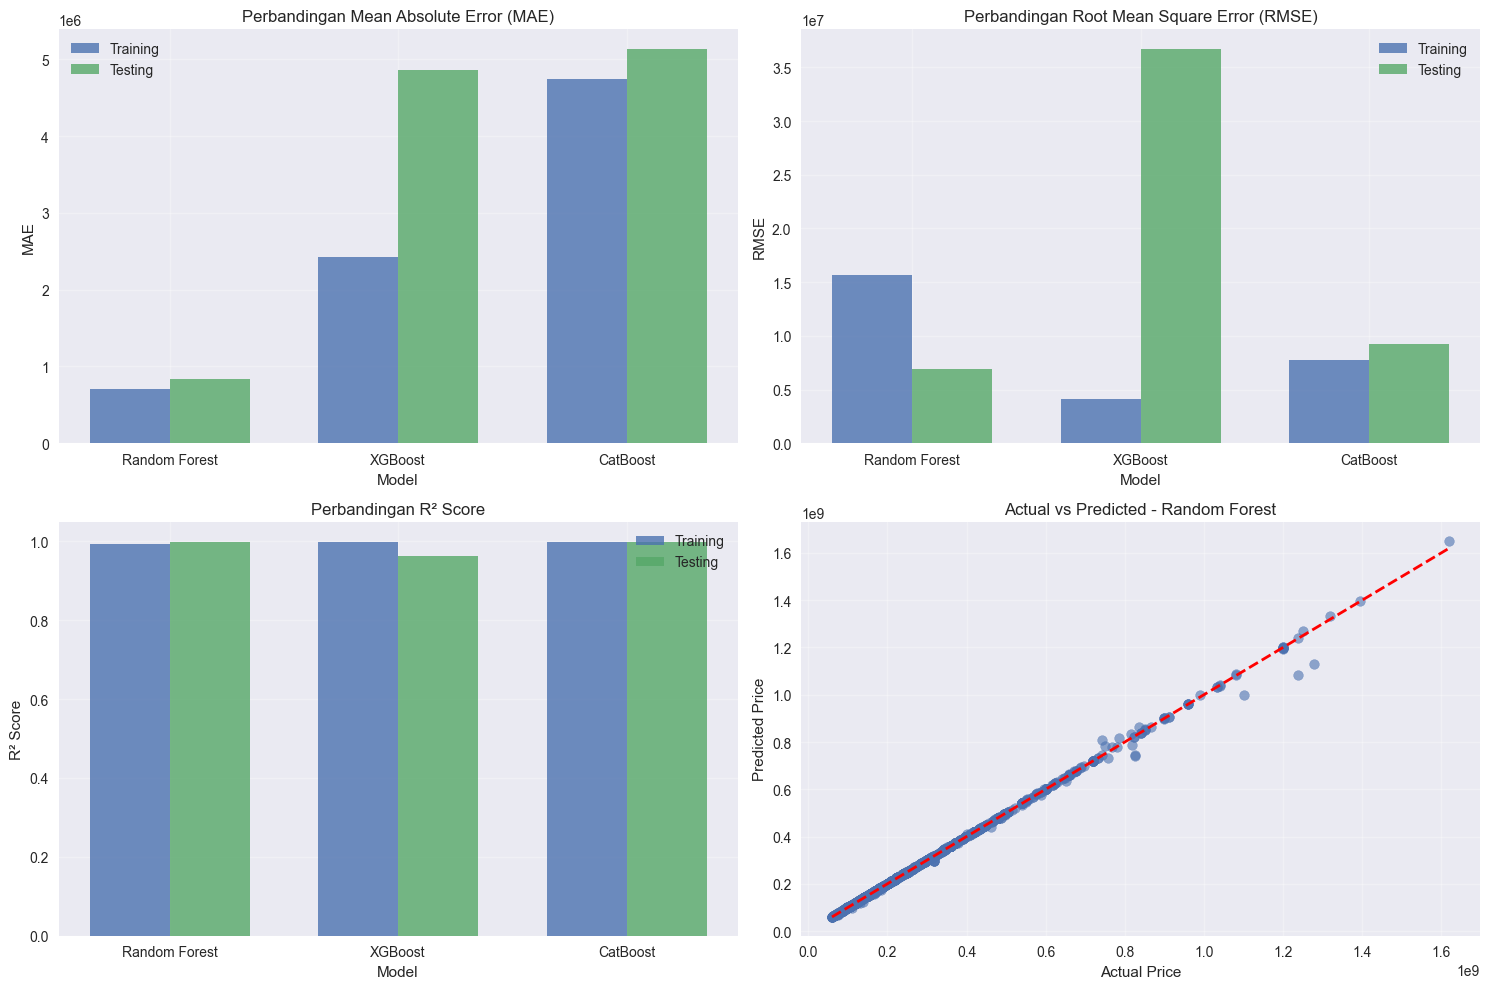


Hasil perbandingan disimpan di: ../ml_model\model_comparison.csv


In [18]:
# Perbandingan Performa Model
print("=== PERBANDINGAN PERFORMA MODEL ===")

# Buat DataFrame perbandingan
comparison_results = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'CatBoost'],
    'MAE_Train': [rf_train_metrics['MAE'], xgb_train_metrics['MAE'], cat_train_metrics['MAE']],
    'RMSE_Train': [rf_train_metrics['RMSE'], xgb_train_metrics['RMSE'], cat_train_metrics['RMSE']],
    'R2_Train': [rf_train_metrics['R2'], xgb_train_metrics['R2'], cat_train_metrics['R2']],
    'MAE_Test': [rf_test_metrics['MAE'], xgb_test_metrics['MAE'], cat_test_metrics['MAE']],
    'RMSE_Test': [rf_test_metrics['RMSE'], xgb_test_metrics['RMSE'], cat_test_metrics['RMSE']],
    'R2_Test': [rf_test_metrics['R2'], xgb_test_metrics['R2'], cat_test_metrics['R2']]
})

print("\nTabel Perbandingan Performa:")
print(comparison_results.round(2))

# Identifikasi model terbaik berdasarkan R2 score pada test set
best_model_idx = comparison_results['R2_Test'].idxmax()
best_model_name = comparison_results.loc[best_model_idx, 'Model']
best_r2_score = comparison_results.loc[best_model_idx, 'R2_Test']

print(f"\nModel Terbaik: {best_model_name} dengan R² Score: {best_r2_score:.4f}")

# Visualisasi perbandingan
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Perbandingan MAE
ax1 = axes[0, 0]
models = comparison_results['Model']
mae_train = comparison_results['MAE_Train']
mae_test = comparison_results['MAE_Test']

x = np.arange(len(models))
width = 0.35

ax1.bar(x - width/2, mae_train, width, label='Training', alpha=0.8)
ax1.bar(x + width/2, mae_test, width, label='Testing', alpha=0.8)
ax1.set_xlabel('Model')
ax1.set_ylabel('MAE')
ax1.set_title('Perbandingan Mean Absolute Error (MAE)')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Perbandingan RMSE
ax2 = axes[0, 1]
rmse_train = comparison_results['RMSE_Train']
rmse_test = comparison_results['RMSE_Test']

ax2.bar(x - width/2, rmse_train, width, label='Training', alpha=0.8)
ax2.bar(x + width/2, rmse_test, width, label='Testing', alpha=0.8)
ax2.set_xlabel('Model')
ax2.set_ylabel('RMSE')
ax2.set_title('Perbandingan Root Mean Square Error (RMSE)')
ax2.set_xticks(x)
ax2.set_xticklabels(models)
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Perbandingan R² Score
ax3 = axes[1, 0]
r2_train = comparison_results['R2_Train']
r2_test = comparison_results['R2_Test']

ax3.bar(x - width/2, r2_train, width, label='Training', alpha=0.8)
ax3.bar(x + width/2, r2_test, width, label='Testing', alpha=0.8)
ax3.set_xlabel('Model')
ax3.set_ylabel('R² Score')
ax3.set_title('Perbandingan R² Score')
ax3.set_xticks(x)
ax3.set_xticklabels(models)
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Scatter plot: Actual vs Predicted untuk model terbaik
ax4 = axes[1, 1]

if best_model_name == 'Random Forest':
    y_pred_best = y_test_pred_rf
elif best_model_name == 'XGBoost':
    y_pred_best = y_test_pred_xgb
else:
    y_pred_best = y_test_pred_cat

ax4.scatter(y_test, y_pred_best, alpha=0.6)
ax4.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax4.set_xlabel('Actual Price')
ax4.set_ylabel('Predicted Price')
ax4.set_title(f'Actual vs Predicted - {best_model_name}')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Simpan hasil perbandingan
comparison_results.to_csv(os.path.join(model_dir, 'model_comparison.csv'), index=False)
print(f"\nHasil perbandingan disimpan di: {os.path.join(model_dir, 'model_comparison.csv')}")

## 10. Kesimpulan dan Prediksi Contoh

Ringkasan hasil dan contoh penggunaan model untuk prediksi harga properti baru.

In [20]:
# Kesimpulan dan Prediksi Contoh
print("=== KESIMPULAN ANALISIS ===")

print("1. Dataset:")
print(f"   - Total data: {len(df_bangunan)} properti")
print(f"   - Features: {len(feature_columns)} variabel")
print(f"   - Target: Harga properti (Rp)")

print("\n2. Model yang Dilatih:")
print("   - Random Forest: Ensemble method dengan multiple decision trees")
print("   - XGBoost: Extreme Gradient Boosting")
print("   - CatBoost: Gradient boosting dengan handling categorical features")

print(f"\n3. Model Terbaik: {best_model_name}")
print(f"   - R² Score: {best_r2_score:.4f}")
print(f"   - MAE: Rp {comparison_results.loc[best_model_idx, 'MAE_Test']:,.0f}")
print(f"   - RMSE: Rp {comparison_results.loc[best_model_idx, 'RMSE_Test']:,.0f}")

# Contoh prediksi dengan data test yang sudah ada
print("\n=== CONTOH PREDIKSI PROPERTI ===")

# Ambil 3 sample dari test set
sample_indices = [0, 10, 50]
for i, idx in enumerate(sample_indices):
    print(f"\nContoh {i+1}:")
    
    # Ambil data sample
    sample_x = X_test.iloc[idx:idx+1]
    actual_price = y_test.iloc[idx]
    
    # Prediksi dengan semua model
    rf_pred = rf_model.predict(sample_x)[0]
    xgb_pred = xgb_model.predict(sample_x)[0]
    cat_pred = catboost_model.predict(sample_x)[0]
    
    print(f"  Spesifikasi:")
    print(f"  - Luas bangunan: {sample_x['luas_bangunan_m2'].iloc[0]:.0f} m²")
    print(f"  - Luas tanah: {sample_x['luas_tanah_m2'].iloc[0]:.0f} m²")
    print(f"  - Kamar tidur: {sample_x['jumlah_kamar_tidur'].iloc[0]:.0f}")
    print(f"  - Kamar mandi: {sample_x['jumlah_kamar_mandi'].iloc[0]:.0f}")
    
    print(f"  Harga Aktual: Rp {actual_price:,.0f}")
    print(f"  Prediksi:")
    print(f"    - Random Forest: Rp {rf_pred:,.0f}")
    print(f"    - XGBoost: Rp {xgb_pred:,.0f}")
    print(f"    - CatBoost: Rp {cat_pred:,.0f}")
    
    # Akurasi prediksi model terbaik
    if best_model_name == 'Random Forest':
        best_pred = rf_pred
    elif best_model_name == 'XGBoost':
        best_pred = xgb_pred
    else:
        best_pred = cat_pred
        
    error_percent = abs((actual_price - best_pred) / actual_price) * 100
    print(f"    - Error {best_model_name}: {error_percent:.2f}%")

print("\n=== RINGKASAN ===")
print("✅ Berhasil melatih 3 model machine learning")
print("✅ Model tersimpan di folder '../ml_model/'")
print("✅ Evaluasi performa tersimpan di 'model_comparison.csv'")
print(f"✅ Model terbaik: {best_model_name}")
print("✅ Model siap digunakan untuk prediksi harga properti")

print(f"\nFile yang dihasilkan:")
print(f"1. {model_path}")
print(f"2. {xgb_model_path}")
print(f"3. {catboost_model_path}")
print(f"4. {os.path.join(model_dir, 'model_comparison.csv')}")

print(f"\nPerforma Model Terbaik ({best_model_name}):")
print(f"- Akurasi (R²): {best_r2_score:.2%}")
print(f"- Error rata-rata: Rp {comparison_results.loc[best_model_idx, 'MAE_Test']:,.0f}")
print(f"- Model dapat memprediksi harga properti dengan akurasi {best_r2_score:.2%}")

=== KESIMPULAN ANALISIS ===
1. Dataset:
   - Total data: 8980 properti
   - Features: 53 variabel
   - Target: Harga properti (Rp)

2. Model yang Dilatih:
   - Random Forest: Ensemble method dengan multiple decision trees
   - XGBoost: Extreme Gradient Boosting
   - CatBoost: Gradient boosting dengan handling categorical features

3. Model Terbaik: Random Forest
   - R² Score: 0.9987
   - MAE: Rp 840,679
   - RMSE: Rp 6,878,854

=== CONTOH PREDIKSI PROPERTI ===

Contoh 1:
  Spesifikasi:
  - Luas bangunan: 190 m²
  - Luas tanah: 162 m²
  - Kamar tidur: 4
  - Kamar mandi: 2
  Harga Aktual: Rp 228,000,000
  Prediksi:
    - Random Forest: Rp 228,164,000
    - XGBoost: Rp 225,171,376
    - CatBoost: Rp 227,994,959
    - Error Random Forest: 0.07%

Contoh 2:
  Spesifikasi:
  - Luas bangunan: 176 m²
  - Luas tanah: 128 m²
  - Kamar tidur: 4
  - Kamar mandi: 3
  Harga Aktual: Rp 217,958,400
  Prediksi:
    - Random Forest: Rp 217,966,066
    - XGBoost: Rp 216,277,648
    - CatBoost: Rp 220,689